In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/criteo_sampled_data.csv')
print(data.head())

   label   I1   I2    I3    I4      I5    I6    I7   I8     I9  ...       C17  \
0      0  1.0    1   5.0   0.0  1382.0   4.0  15.0  2.0  181.0  ...  e5ba7672   
1      0  2.0    0  44.0   1.0   102.0   8.0   2.0  2.0    4.0  ...  07c540c4   
2      0  2.0    0   1.0  14.0   767.0  89.0   4.0  2.0  245.0  ...  8efede7f   
3      0  NaN  893   NaN   NaN  4392.0   NaN   0.0  0.0    0.0  ...  1e88c74f   
4      0  3.0   -1   NaN   0.0     2.0   0.0   3.0  0.0    0.0  ...  1e88c74f   

        C18       C19       C20       C21       C22       C23       C24  \
0  f54016b9  21ddcdc9  b1252a9d  07b5194c       NaN  3a171ecb  c5c50484   
1  b04e4670  21ddcdc9  5840adea  60f6221e       NaN  3a171ecb  43f13e8b   
2  3412118d       NaN       NaN  e587c466  ad3062eb  3a171ecb  3b183c5c   
3  74ef3502       NaN       NaN  6b3a5ca6       NaN  3a171ecb  9117a34a   
4  26b3c7a7       NaN       NaN  21c9516a       NaN  32c7478e  b34f3128   

        C25       C26  
0  e8b83407  9727dd16  
1  e8b83407  7

In [3]:
data.shape

(600000, 40)

# 数据处理
## 将数值型数据和类别型数据分开

In [4]:
cols = data.columns.values
dense_feats = [f for f in cols if 'I' in f]
sparse_feats = [f for f in cols if 'C' in f]

In [5]:
def process_dense_feats(data, feats):
    d = data.copy()
    ##用0做缺失值填充，特征工程时可以用均值或其他值进行填充
    d = d[feats].fillna(0.0)
    for i in feats:
        ## 进行log转换消除长尾效应
        d[i] = d[i].apply(lambda x: np.log(x + 1) if x > -1 else -1)
    return d

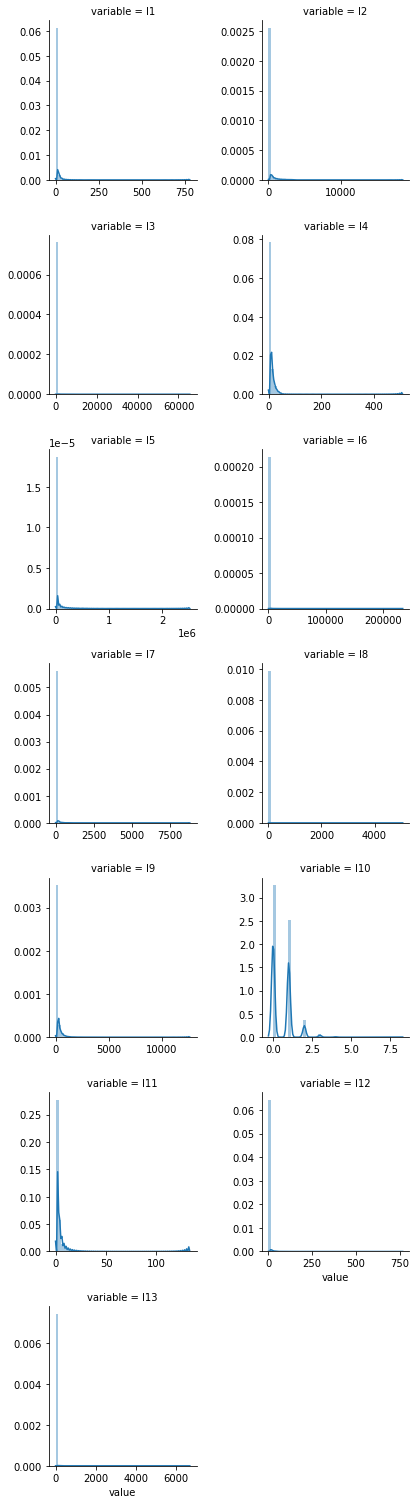

In [6]:
import seaborn as sns
##查看数值型数据的分布   
f = pd.melt(data, value_vars=dense_feats)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value', kde_kws={'bw': 0.1})

##### 可以看出经过对数转换后的数据分布，更趋近与正态分布

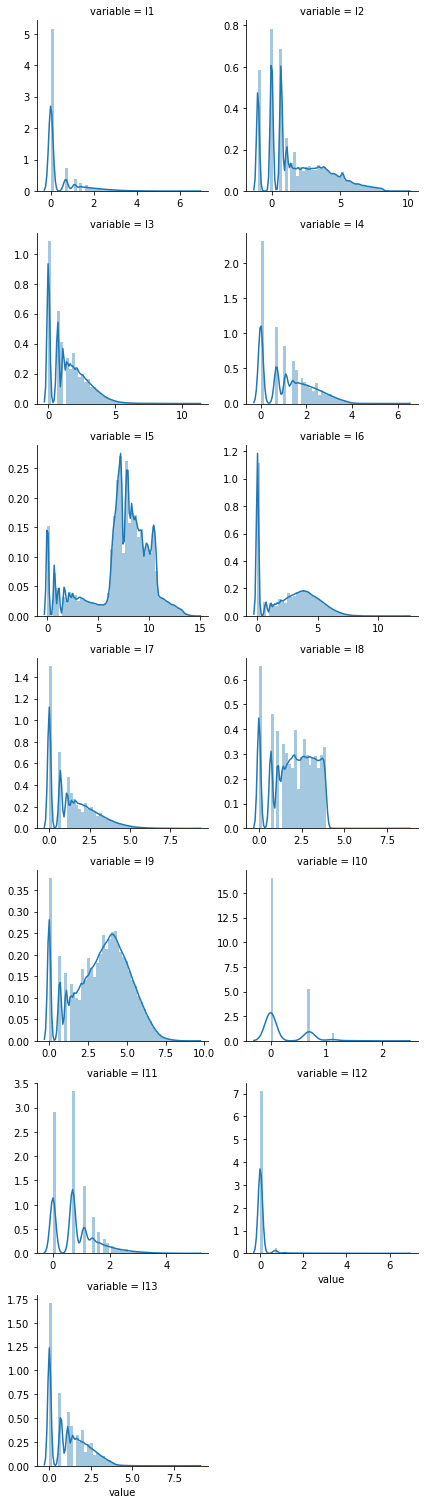

In [7]:
##进行对数转换后的分布
data_dense = process_dense_feats(data, feats=dense_feats)

f = pd.melt(data_dense, value_vars=dense_feats)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value', kde_kws={'bw': 0.1})

In [8]:
from sklearn.preprocessing import LabelEncoder

def process_sparse_feats(data, feats):
    d = data.copy()
    ##将缺失值填充为-1
    d = d[feats].fillna("-1")
    for i in feats:
        le = LabelEncoder()
        d[i] = le.fit_transform(d[i])
    return d

In [9]:
data_sparse = process_sparse_feats(data, feats=sparse_feats)

In [10]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

    
f = pd.melt(data, id_vars=['label'], value_vars=sparse_feats)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(boxplot, 'value', 'label', kde_kws={'bw':0.1})

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ff87755b560> (for post_execute):


KeyboardInterrupt: 

In [11]:
total_data = pd.concat([data_dense, data_sparse], axis=1)
total_data['label'] = data['label']

## 开始构建模型 

### 初始化数据输入的容器

In [12]:
dense_inputs = []
from tensorflow.keras import layers as Kl
##这里使用keras，对应tf.placeholder
for i in dense_feats:
    ##这里对应tf的tf.placeholder(tf.float32, [None, 1], name=i)
    _inputs = Kl.Input([1], name=i)
    dense_inputs.append(_inputs)

In [13]:
##对应tf.concat(dense_inputs, axis=1, name='inputs_combine')
concat_dense_inputs = Kl.Concatenate(axis=1)(dense_inputs) ##shape: ?, 1, 13


In [14]:
sparse_inputs = []
for i in sparse_feats:
    _inputs = Kl.Input([1], name=i)
    sparse_inputs.append(_inputs)

In [15]:
embed_dims = 8
sparse_embed = []
for i, _inputs in enumerate(sparse_inputs):
    f = sparse_feats[i]
    voc_size = data[f].nunique()
    _embed = Kl.Flatten()(Kl.Embedding(voc_size+1, embed_dims, embeddings_regularizer=tf.keras.regularizers.l2(0.7))(_inputs))
    sparse_embed.append(_embed)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
concat_sparse_inputs = Kl.Concatenate(axis=1)(sparse_embed)

In [17]:
concat_sparse_inputs

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 208) dtype=float32>

### 将类别型数据的embedding值和数值型数据拼接到一起

In [18]:
embed_inputs = Kl.Concatenate(axis=1)([concat_sparse_inputs, concat_dense_inputs])


In [19]:
embed_inputs

<tf.Tensor 'concatenate_2/concat:0' shape=(?, 221) dtype=float32>

In [20]:
concat_dense_inputs

<tf.Tensor 'concatenate/concat:0' shape=(?, 13) dtype=float32>

### cross network, 交叉层的处理 公式：X_l+1 = X0 * X_l_T * W + b_0 + X_l

#### tensorflow中的外积运算，使用tf.transpose没办法实现转置，所以需要使用reshape

In [92]:
##实现一层cross network
def cross_network(x0, xl):
    embed_size = xl.shape[-1] ## x1.shape[1]
    w = tf.Variable(tf.random.truncated_normal(shape=(embed_size,), stddev=0.01))  ##w:shape = n, x0(n,m) * x1(m, n) * w(n,1)
    b = tf.Variable(tf.zeros(shape=(embed_size,)))
#     print(w)
#     print(b)
    xl_w = tf.tensordot(xl, w, axes=1)
    print(x0)
    print(xl_w)
    x0_xl_w = x0 * xl_w
#     print(x0_xl_w)
    return x0_xl_w + b + xl
def cross_network_copy(x0, xl):
    """
    实现一层cross layer
    @param x0: 特征embeddings
    @param xl: 第l层的输出结果
    """
    # 1.获取xl层的embedding size
    embed_dim = xl.shape[-1]
    # 2.初始化当前层的W和b
    w = tf.Variable(tf.random.truncated_normal(shape=(embed_dim,), stddev=0.01))
    b = tf.Variable(tf.zeros(shape=(embed_dim,)))
    # 3.计算feature crossing
    x_lw = tf.tensordot(tf.reshape(xl, [-1, 1, embed_dim]), w, axes=1)
    print(x0)
    print(x_lw)
    cross = x0 * x_lw 
    return cross + b + xl

In [93]:
def build_cross_layer(x0, num_layer=3):
    """
        构建多层交叉层
    """
    x1 = x0
    for i in range(num_layer):
        x1 = cross_network(x0, x1)
    return x1

In [94]:
cross_layer = build_cross_layer(embed_inputs, 1)

In [34]:
cross_layer

<tf.Tensor 'add_11:0' shape=(?, 221) dtype=float32>

### DNN部分

In [48]:
##DNN层
fc_layer_1 = Kl.Dense(128, activation='relu')(embed_inputs)
fc_layer_2 = Kl.Dense(128, activation='relu')(fc_layer_1)
fc_layer_output = Kl.Dense(128, activation='relu')(fc_layer_2)

In [49]:
fc_layer_output

<tf.Tensor 'dense_8/Relu:0' shape=(?, 128) dtype=float32>

In [50]:
cross_layer

<tf.Tensor 'add_29:0' shape=(?, 221) dtype=float32>

In [96]:
with tf.Session() as sess:
# layer_out = tf.concat([cross_layer, fc_layer_3], axis=1)
    sess.run(tf.global_variables_initializer())
    stack_layer = Kl.Concatenate()([cross_layer, fc_layer_output])

In [67]:
stack_layer

<tf.Tensor 'concatenate_11/concat:0' shape=(?, 349) dtype=float32>

In [97]:
# out_final = tf.layers.dense(layer_out, 1, activation=tf.nn.sigmoid)
# sess = tf.Session()

# sess.run(tf.global_variables_initializer())
output_layer = Kl.Dense(1, activation='sigmoid', use_bias=True)(stack_layer)

In [69]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

### 编译模型


In [98]:
model = Model(dense_inputs + sparse_inputs, output_layer) ##参数1: 输入，参数2:输出

In [75]:
plot_model(model, to_file='dcn.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [72]:
!pip install pydot

In [73]:
!pip install pydotplus

     |████████████████████████████████| 278 kB 459 kB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=68729f0eac8511939c9ec955485a181d9c835759be63e563e3d2385f7f6fb41e
  Stored in directory: /Users/lvsongke/Library/Caches/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


In [74]:
!sudo apt-get install graphviz

Password:


In [100]:
##选择损失函数和优化器
model.compile(optimizer="adam", 
              loss="binary_crossentropy", 
              metrics=["binary_crossentropy", tf.keras.metrics.AUC(name='auc')])

### 开始训练 

In [104]:
from tensorflow.keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./logs_dcn',  # log 目录
                 histogram_freq=0,  
                 write_graph=True,  
                 write_grads=True, 
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [78]:
train_data = total_data.loc[:500000-1]
valid_data = total_data.loc[500000:]

In [79]:
train_dense_x = [train_data[f].values for f in dense_feats]
train_sparse_x = [train_data[f].values for f in sparse_feats]

In [80]:
train_label = [train_data['label'].values]

In [81]:
val_dense_x = [valid_data[f].values for f in dense_feats]
val_sparse_x = [valid_data[f].values for f in sparse_feats]

In [82]:
val_label = [valid_data['label'].values]

In [105]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    model.fit(train_dense_x+train_sparse_x, 
              train_label, epochs=5, batch_size=128,
              validation_data=(val_dense_x+val_sparse_x, val_label),
              callbacks=[tbCallBack]
             )

Train on 500000 samples, validate on 100000 samples
Epoch 1/5
500000/500000 [==============================] - 138s 275us/sample - loss: 15.2635 - binary_crossentropy: 0.5062 - auc: 0.7234 - val_loss: 0.5425 - val_binary_crossentropy: 0.5075 - val_auc: 0.7281
Epoch 2/5
500000/500000 [==============================] - 130s 260us/sample - loss: 0.5618 - binary_crossentropy: 0.4986 - auc: 0.7355 - val_loss: 0.6003 - val_binary_crossentropy: 0.5041 - val_auc: 0.7319
Epoch 3/5
500000/500000 [==============================] - 132s 263us/sample - loss: 0.5894 - binary_crossentropy: 0.4960 - auc: 0.7393 - val_loss: 0.6111 - val_binary_crossentropy: 0.5023 - val_auc: 0.7352
Epoch 4/5
500000/500000 [==============================] - 135s 270us/sample - loss: 0.5876 - binary_crossentropy: 0.4945 - auc: 0.7412 - val_loss: 0.5961 - val_binary_crossentropy: 0.5018 - val_auc: 0.7364
Epoch 5/5
500000/500000 [==============================] - 136s 273us/sample - loss: 0.5889 - binary_crossentropy: 0.49

In [103]:
!tensorboard --logdir ./logs

W0708 17:48:24.024832 123145415622656 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0708 17:48:24.031090 123145415622656 plugin_event_accumulator.py:302] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W0708 17:48:24.040287 123145415622656 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0708 17:48:24.046203 123145415622656 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0708 17:48:24.053781 123145415622656 plugin_event_accumulator.py:294] Found more than one graph event 